In [2]:
from pathlib import Path
from src.models import ConvLSTMPredictionModel
from src.dataset import DatasetGenerator, scale_to_01
import keras
from matplotlib import pyplot as plt
import numpy as np
from src.losses import kNDVILoss

2026-01-02 20:12:31.391415: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-02 20:12:31.430431: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-02 20:12:32.310469: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/me/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.p

In [3]:
DATASET_PATH = Path("/home/me/workspace/probformer/data/greenearthnet/train/29SND")

SPLINE_PATH = Path("/home/me/workspace/bspline_ndvi")

LOGS_PATH = SPLINE_PATH / "logs"

CHECKPOINTS_PATH = SPLINE_PATH / "checkpoints"

In [4]:
def customize_axes(fig):
    fig.tight_layout()
    for i, ax in enumerate(fig.axes):
        ax.tick_params(
            bottom=False,
            left=False,
            labelbottom=False, 
            labelleft=False
        )

    plt.subplots_adjust(wspace=0, hspace=0)

In [5]:

BEST_CHECKPOINT_PATH = CHECKPOINTS_PATH / "model_at_68.keras"
model = keras.models.load_model(BEST_CHECKPOINT_PATH)
if not isinstance(model, ConvLSTMPredictionModel):
    raise ValueError("Model is not instance of ConvLSTMPredictionModel")

I0000 00:00:1767395553.075533   67703 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4089 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


X Sample shapes:
time (1, 18, 3)
sentinel2 (1, 18, 128, 128, 4)
cloudmask (1, 18, 128, 128, 1)
landcover (1, 128, 128, 10)
Y Sample shapes:
sentinel2 (1, 12, 128, 128, 4)
cloudmask (1, 12, 128, 128, 1)
deltas (1, 12, 128, 128, 4)


2026-01-02 20:12:35.893084: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701
2026-01-02 20:12:36.595248: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


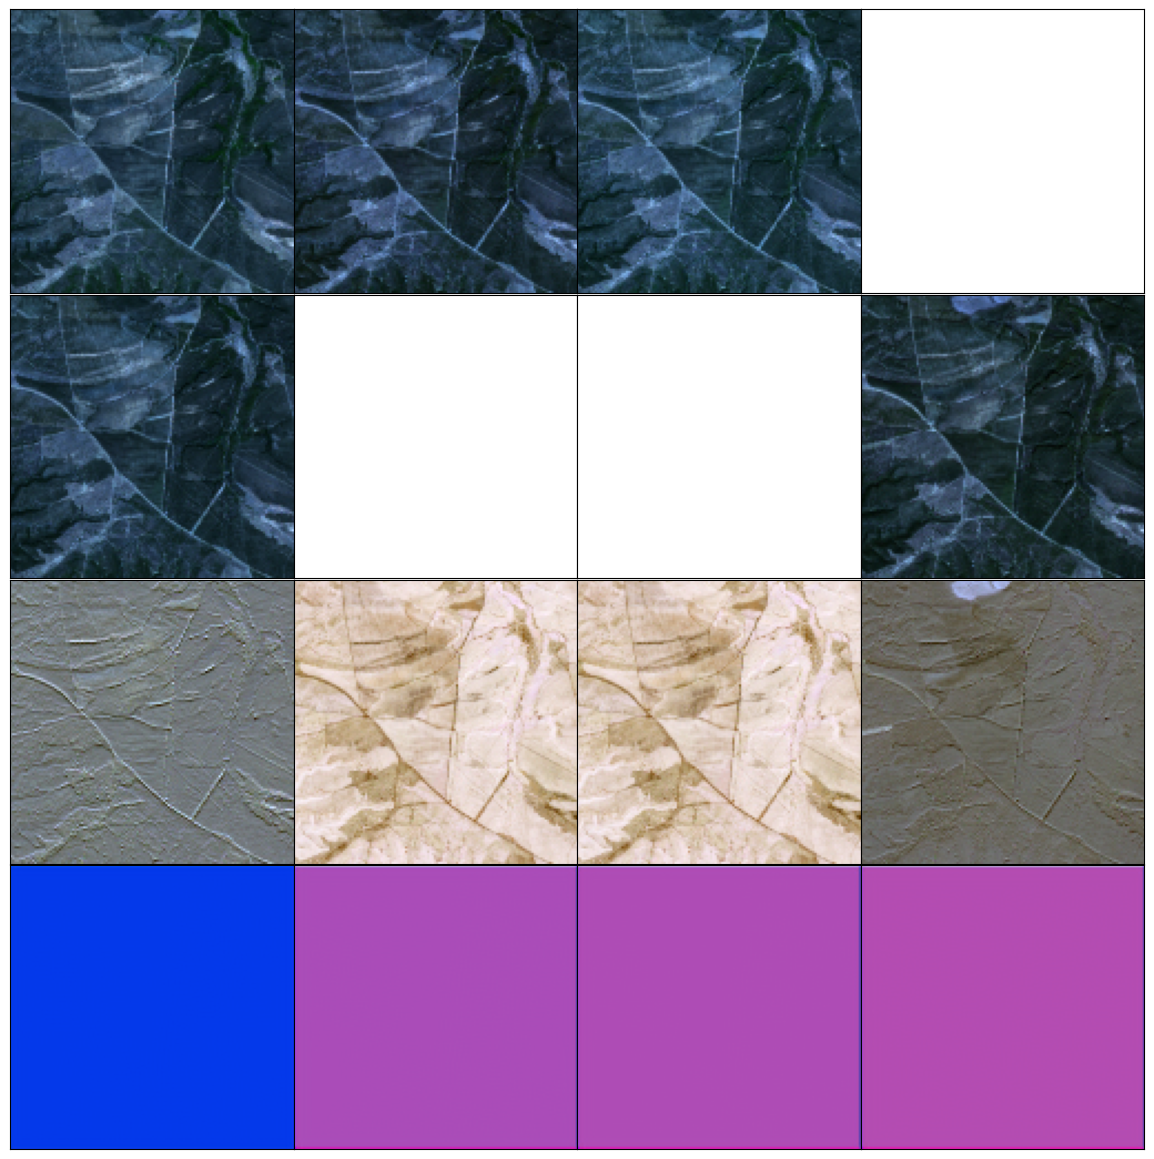

In [6]:
dataset = DatasetGenerator(DATASET_PATH).get_dataset()

fig, axes = plt.subplots(4, 4, figsize=(12,12))

for x, y in dataset.batch(1).shuffle(1, 42).take(1):
    print("X Sample shapes:")
    for key, val in x.items():
        print(key, val.shape)
    
    print("Y Sample shapes:")
    for key, val in y.items():
        print(key, val.shape)

    predicted = model(x)
    predicted = predicted["deltas"]

    for i in range(4):
        composite_x = scale_to_01(x["sentinel2"][0, -i, :, :, 0:3])
        cloudmask_x = x["cloudmask"][0, -i, :, :, 0]
        cloudmask_x = np.where(cloudmask_x==0, np.nan, cloudmask_x)
        
        composite_y = scale_to_01(y["sentinel2"][0, -i, :, :, 0:3])
        cloudmask_y = y["cloudmask"][0, -i, :, :, 0]
        cloudmask_y = np.where(cloudmask_y==0, np.nan, cloudmask_y)
        
        deltas = scale_to_01(y["deltas"][0, -i, :, :, 0:3])
        
        pred_deltas = scale_to_01(predicted[0, -i, :, :, 1:4])

        axes[0][i].imshow(composite_x)
        # axes[0][i].imshow(cloudmask_x)
        
        axes[1][i].imshow(composite_y)
        # axes[1][i].imshow(cloudmask_y)

        axes[2][i].imshow(deltas)

        axes[3][i].imshow(pred_deltas)
        
customize_axes(fig)